## Fitness Analysis & Dashboard - Reviewing Fitbit Data

I downloaded the fitbit files from fitbit.com, taken from a Fitbit HR 3. This is nearly a year of data, and ~500mb of data. It is currently being stored in the .gitignore due to the size. Will compress/limit depending on the direction of the analysis.

**Some initial questions and thoughts:**

- coffee after 2pm affect?
- lost weight?
- daily workload?
- workouts?
- shopping habits?
- heart rate through night vs morning, vs evening - overall seasonality

**Initial Goals**
- Create a Heroku application with the data in a dashboard
- chech summary statistics

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import os
import re
import json

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

### Data Retrieval

Current readtime is >5 minutes, will compress later. 12:46 to 

In [2]:
# Only files matching heart_rate pattern
files = [f for f in os.listdir('user-site-export') if re.match(r'heart_rate*', f)]
print(len(files))
files[:5]

329


['heart_rate-2018-11-01.json',
 'heart_rate-2018-11-02.json',
 'heart_rate-2018-11-03.json',
 'heart_rate-2018-11-04.json',
 'heart_rate-2018-11-05.json']

In [3]:
df = pd.DataFrame(columns=['dateTime', 'value']) #empty dataframe for initialization

for i in range(len(files)):
    with open(os.path.join('user-site-export',files[i]), "r") as read_file:
        data = pd.read_json(read_file)
    df = pd.concat([df,data])
print(df.shape)
df.head(5)

(4391373, 2)


,dateTime,value
0,2018-11-02 03:56:44,"{'bpm': 70, 'confidence': 0}"
1,2018-11-02 03:57:03,"{'bpm': 70, 'confidence': 1}"
2,2018-11-02 03:57:18,"{'bpm': 70, 'confidence': 1}"
3,2018-11-02 03:57:23,"{'bpm': 90, 'confidence': 1}"
4,2018-11-02 03:57:28,"{'bpm': 83, 'confidence': 1}"


### Date Wrangling and Formatting
- df is the initial dataframe with standard index
- ts is with datetime as the index

In [4]:
# Extracting the bpm from the dictionary in the value column, creating 2 new columns
df['bpm'] = df.value.apply(lambda x: x['bpm'])
df['confidence'] = df.value.apply(lambda x: x['confidence'])

In [5]:
df.drop('value', axis =1, inplace=True) # dropping value column

In [6]:
df.head(5)

,dateTime,bpm,confidence
0,2018-11-02 03:56:44,70,0
1,2018-11-02 03:57:03,70,1
2,2018-11-02 03:57:18,70,1
3,2018-11-02 03:57:23,90,1
4,2018-11-02 03:57:28,83,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4391373 entries, 0 to 10873
Data columns (total 3 columns):
dateTime      datetime64[ns]
bpm           int64
confidence    int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 134.0 MB


In [ ]:
 stop error

In [10]:
# Make ts object with date as the index 

ts = df.set_index('dateTime')
ts.info()
ts.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4391373 entries, 2018-11-02 03:56:44 to 2020-01-05 04:59:50
Data columns (total 2 columns):
bpm           int64
confidence    int64
dtypes: int64(2)
memory usage: 100.5 MB


,bpm,confidence
dateTime,,
2018-11-02 03:56:44,70,0
2018-11-02 03:57:03,70,1
2018-11-02 03:57:18,70,1
2018-11-02 03:57:23,90,1
2018-11-02 03:57:28,83,1


### Timeplot of BPM Daily Average
- Resampling the ts dataframe to "Daily" average, rather than all readings
- Below it show 328 resampled days with the earliest reading from 2018-11-02, and a shape of 430 indicates there is missing data. 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 430 entries, 2018-11-02 to 2020-01-05
Freq: D
Data columns (total 2 columns):
bpm           328 non-null float64
confidence    328 non-null float64
dtypes: float64(2)
memory usage: 10.1 KB


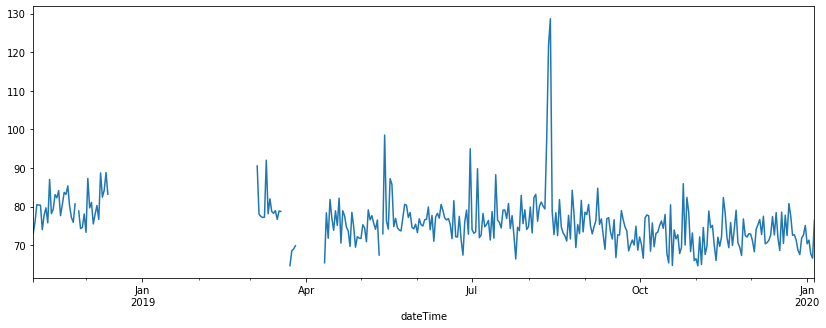

In [19]:
df_daily = ts.resample('D')
df_daily_mean = df_daily.mean()
df_daily_mean.info()

df_daily_mean['bpm'].plot(figsize = (14,5));

### Timeplot of BPM Monthly Average

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2018-11-30 to 2020-01-31
Freq: M
Data columns (total 2 columns):
bpm           13 non-null float64
confidence    13 non-null float64
dtypes: float64(2)
memory usage: 360.0 bytes


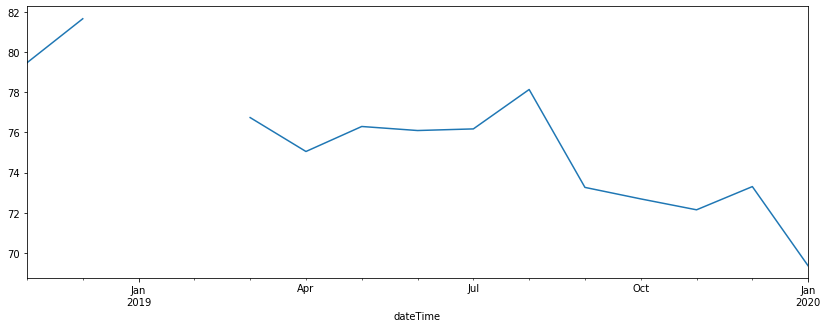

In [21]:
df_monthly = ts.resample('M')
df_monthly_mean = df_monthly.mean()
df_monthly_mean.info()

df_monthly_mean['bpm'].plot(figsize = (14,5));

### Time Series Review

These autocorrelations appear non-random, or significantly non-zero. Weekly seasonality at 7, 14, 21 stands out, as well as the initial few days near it. 

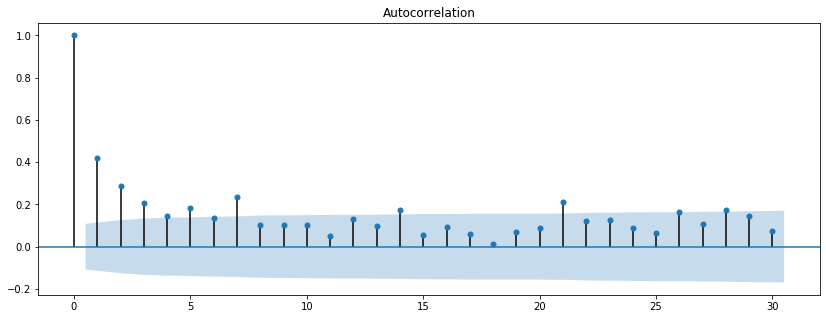

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(df_daily_mean[['bpm']].dropna(), lags=30);

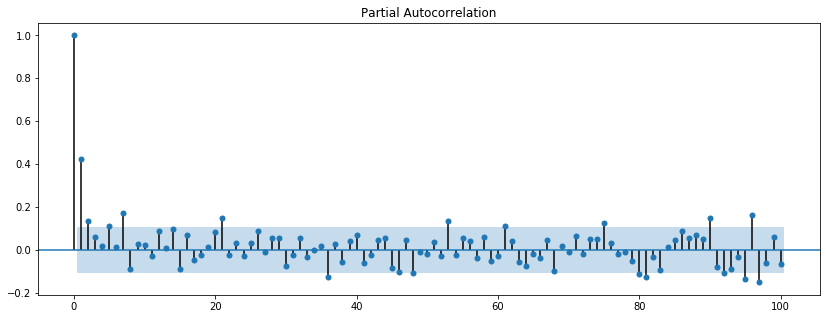

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(df_daily_mean[['bpm']].dropna(), lags=100);

### Sources
- https://pandas.pydata.org/pandas-docs/version/0.15/visualization.html
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/